<a href="https://colab.research.google.com/github/amirahammadii/autism-detection/blob/main/autism_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Timestamp', 'Please choose a category you belong to',
       'Are you a Nigerian', 'Which age group does your child belong to',
       'Sex of child', 'Please state your country of residence',
       'Which type of disability do he/she have',
       'Please what is the age of the Mother when the child was born',
       'Is your child Formerly diagnosed',
       'If Diagnosis is yes , what was his/her diagnosis? (DSM 4 Diagnosis)',
       'At what age was the child diagnosed', 'Where was the diagnosis done?',
       'Is your child ',
       'Please can you give us some of your child’s unique behaviors that prompted you to go for a diagnosis',
       'How can you rate your child's deficits in social communication and social interaction',
       'How can you rate your Childs nonverbal communicative behaviors capabilities (i.e abnormalities in eye contact, body language or deficits in understanding, use of gestures, total lack of facial expressions and nonverbal communication)',
  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


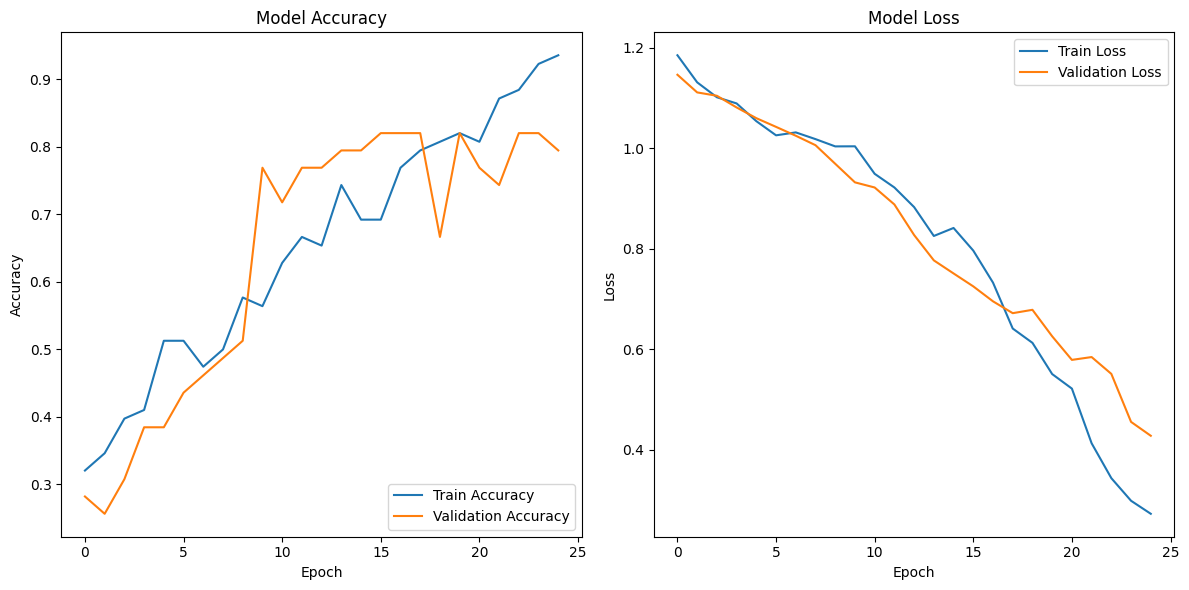

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample

# Charger les données
data = pd.read_excel('/content/Dataset_for_Autism_Diagnosis.xlsx')

# Afficher les noms des colonnes pour vérification
print(data.columns)

# Nettoyage et préparation des textes
def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', str(text).lower())
    return text

# Convertir les labels
def convert_label(label):
    if label == 'Level 1 (Mild Autism)':
        return 0
    elif label == 'Level 2 (Moderate Autism)':
        return 1
    elif label == 'Level 3 (Severe Autism)':
        return 2
    else:
        return -1

# Ajuster les noms de colonnes selon la sortie de data.columns
data['processed_text'] = data['Please can you give us some of your child’s unique behaviors that prompted you to go for a diagnosis'].apply(clean_text)
data['social_deficits'] = data['How can you rate your child\'s deficits in social communication and social interaction']
data['nonverbal_communication'] = data['How can you rate your Childs nonverbal communicative behaviors capabilities (i.e abnormalities in eye contact, body language or deficits in understanding, use of gestures, total lack of facial expressions and nonverbal communication)']
data['relationships'] = data['Can your Child develop, maintain and understand relationships(as in difficulties in sharing imaginative play or in making friends and absence of interest in peers.)']
data['sensory_reactivity'] = data['How is his/her Hyporeactivity to  sensory aspects of the environment (i.e can he differentiate pain/temperature,  respond to specific sounds or textures, do excessive smelling or touching of objects)']
data['other_challenges'] = data['Please what other challenges is your childs diagnosed apart from Autism']
data['labels'] = data['If Diagnosis is yes , what was his/her diagnosis? (DSM 5 Diagnosis)'].apply(convert_label)

# Filtrer les données
data = data[data['labels'] != -1]

# Encoder et standardiser les autres caractéristiques
label_encoders = {}
for column in ['social_deficits', 'nonverbal_communication', 'relationships', 'sensory_reactivity', 'other_challenges']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

scaler = StandardScaler()
other_features = data[['social_deficits', 'nonverbal_communication', 'relationships', 'sensory_reactivity', 'other_challenges']]
other_features_scaled = scaler.fit_transform(other_features)

# Vérifier la distribution des données et équilibrer le dataset
class_0 = data[data['labels'] == 0]
class_1 = data[data['labels'] == 1]
class_2 = data[data['labels'] == 2]

max_size = max(len(class_0), len(class_1), len(class_2))

class_0_resampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_resampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)
class_2_resampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

data_balanced = pd.concat([class_0_resampled, class_1_resampled, class_2_resampled])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Tokenization et séquençage des textes
tokenizer_lstm = Tokenizer(num_words=2000, split=' ')
tokenizer_lstm.fit_on_texts(data_balanced['processed_text'].values)
X_text = tokenizer_lstm.texts_to_sequences(data_balanced['processed_text'].values)
X_text = pad_sequences(X_text, maxlen=50)

# Extraire et standardiser les autres caractéristiques
other_features_balanced = data_balanced[['social_deficits', 'nonverbal_communication', 'relationships', 'sensory_reactivity', 'other_challenges']]
other_features_scaled_balanced = scaler.transform(other_features_balanced)

# Combiner les textes et les autres caractéristiques
Y = pd.get_dummies(data_balanced['labels']).values
X_train_text, X_test_text, X_train_other, X_test_other, Y_train, Y_test = train_test_split(X_text, other_features_scaled_balanced, Y, test_size=0.33, random_state=42)

# Construire et entraîner le modèle LSTM
text_input = Input(shape=(50,), name='text_input')
embedding = Embedding(input_dim=2000, output_dim=128, input_length=50)(text_input)
spatial_dropout = SpatialDropout1D(0.3)(embedding)
lstm1 = LSTM(196, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(spatial_dropout)
lstm2 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(lstm1)

other_input = Input(shape=(X_train_other.shape[1],), name='other_input')
dense_other = Dense(32, activation='relu')(other_input)

combined = concatenate([lstm2, dense_other])
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=[text_input, other_input], outputs=[output])

optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_train_text, X_train_other], Y_train, epochs=25, batch_size=32, validation_data=([X_test_text, X_test_other], Y_test), callbacks=[early_stopping])

# Évaluer le modèle
score, acc = model.evaluate([X_test_text, X_test_other], Y_test, verbose=2)
print(f"Model Score: {score}")
print(f"Model Accuracy: {acc}")

# Sauvegarder le modèle
model.save('autism_lstm_model_v2.h5')

# Afficher l'historique de l'entraînement
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'predictions' are the predictions of your model
# And 'Y_test' are the actual labels in one-hot format used in your previous sections
y_true = Y_test.argmax(axis=1)
predictions = model.predict([X_test_text, X_test_other])
y_pred = predictions.argmax(axis=1)

# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=['Mild Autism', 'Moderate Autism', 'Severe Autism'])

print(report)


2/2 [==============================] - 0s 38ms/step
                 precision    recall  f1-score   support

    Mild Autism       0.92      0.69      0.79        16
Moderate Autism       0.73      0.89      0.80         9
  Severe Autism       0.88      1.00      0.93        14

       accuracy                           0.85        39
      macro avg       0.84      0.86      0.84        39
   weighted avg       0.86      0.85      0.84        39



2/2 [==============================] - 0s 59ms/step


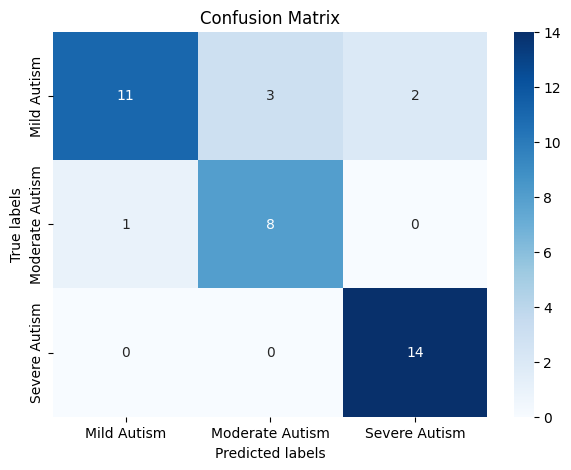

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'Y_test' and the 'model' are already defined and used previously
y_true = Y_test.argmax(axis=1)  # Convert from one-hot to simple labels if necessary
# If predictions are not previously calculated or you want to ensure independence:
predictions = model.predict([X_test_text, X_test_other])
y_pred = predictions.argmax(axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Mild Autism', 'Moderate Autism', 'Severe Autism'], yticklabels=['Mild Autism', 'Moderate Autism', 'Severe Autism'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle

# Save the tokenizer (Make sure you run this cell before trying to load it)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
!zip tokenizer.zip tokenizer.pickle

  adding: tokenizer.pickle (deflated 39%)


In [ ]:
!unzip tokenizer.zip  # Décompresse le fichier dans Colab

import pickle

# Charger le tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


Archive:  tokenizer.zip
replace tokenizer.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Vérifier que le tokenizer a bien été chargé
print(tokenizer.word_index)  # Affiche quelques mots de l'index pour confirmer le chargement


{'and': 1, 'of': 2, 'verbal': 3, 'non': 4, 'lack': 5, 'speech': 6, 'communication': 7, 'not': 8, 'he': 9, 'hyperactive': 10, 'to': 11, 'no': 12, 'attention': 13, 'stimming': 14, 'the': 15, 'at': 16, 'behaviour': 17, 'eye': 18, 'contact': 19, 'his': 20, 'name': 21, 'differences': 22, 'was': 23, 'age': 24, 'nan': 25, 'a': 26, 'she': 27, 'all': 28, 'odd': 29, 'socialization': 30, 'abnormal': 31, 'behaviors': 32, 'respond': 33, 'objects': 34, 'repeatitive': 35, 'hyposensitivity': 36, 'niche': 37, 'interests': 38, 'but': 39, 'on': 40, 'delay': 41, 'sleep': 42, 'command': 43, 'following': 44, 'recognition': 45, 'are': 46, 'zero': 47, 'walk': 48, 'flapping': 49, 'learning': 50, 'hyper': 51, 'behavioral': 52, 'bit': 53, 'hyperactivity': 54, 'is': 55, 'delayed': 56, 'milestones': 57, 'when': 58, 'stopped': 59, 'talking': 60, 'severe': 61, '2': 62, 'social': 63, 'behavior': 64, 'stop': 65, 'from': 66, 'something': 67, 'bad': 68, 'good': 69, 'aggression': 70, 'delays': 71, 'my': 72, 'child': 73, 

In [ ]:
!ls /content


 autism_lstm_model_v2.h5  'Dataset_ for_ Autism_ Diagnosis.xlsx'   sample_data	 tokenizer.pickle


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

# Vérifie que le fichier est là
!ls "/content/autism_lstm_model_v2.h5"


/content/autism_lstm_model_v2.h5


In [ ]:
from keras.models import load_model

try:
    model = load_model('/content/autism_lstm_model_v2.h5')
except OSError as e:
    print("Le modèle n'a pas pu être chargé. Vérifie le chemin du fichier :", e)


In [ ]:
from keras.models import load_model

try:
    model = load_model('/content/autism_lstm_model_v2.h5')
except OSError as e:
    print("Le modèle n'a pas pu être chargé. Vérifie le chemin du fichier :", e)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Chargement et préparation du modèle
try:
    model = load_model('/content/autism_lstm_model_v2.h5')
    print("Modèle chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")

# Initialisation des LabelEncoder pour les variables catégorielles
label_encoder_social = LabelEncoder()
label_encoder_nonverbal = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_sensory = LabelEncoder()

# Hypothétique liste de catégories connues pour chaque encoder
categories_social = ['Mild', 'Moderate', 'Severe']
categories_nonverbal = ['Good', 'Poor', 'Very good']
categories_relationship = ['Yes', 'No', 'Sometimes']
categories_sensory = ['Severe' , 'Moderate', 'Mild']

# Entraînement des encoders avec les catégories
label_encoder_social.fit(categories_social)
label_encoder_nonverbal.fit(categories_nonverbal)
label_encoder_relationship.fit(categories_relationship)
label_encoder_sensory.fit(categories_sensory)

# Définition des widgets pour collecter les réponses
unique_behaviors = widgets.Textarea(description='Unique Behaviors:', placeholder='Describe behaviors that prompted diagnosis')
social_deficits = widgets.RadioButtons(options=categories_social, description='Social deficits:')
nonverbal_communication = widgets.RadioButtons(options=categories_nonverbal, description='Nonverbal communication:')
relationships = widgets.RadioButtons(options=categories_relationship, description='Can develop relationships:')
sensory_reactivity = widgets.RadioButtons(options=categories_sensory, description='Sensory reactivity:')
submit_button = widgets.Button(description="Submit Answers")

# Exemple de tokenizer à définir (à remplacer par votre tokenizer réel)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
# Supposons que le tokenizer est déjà entraîné avec les données appropriées

# Fonction pour préparer les données avant prédiction
def prepare_data(behaviors_text, social_score, nonverbal_score, relationship_status, sensory_score):
    cleaned_text = behaviors_text.lower()
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(tokenized_text, maxlen=50)

    social_encoded = label_encoder_social.transform([social_score])[0]
    nonverbal_encoded = label_encoder_nonverbal.transform([nonverbal_score])[0]
    relationship_encoded = label_encoder_relationship.transform([relationship_status])[0]
    sensory_encoded = label_encoder_sensory.transform([sensory_score])[0]

    missing_feature = 0  # Placeholder for missing feature

    categorical_features = np.array([social_encoded, nonverbal_encoded, relationship_encoded, sensory_encoded, missing_feature]).reshape(1, -1)

    return padded_text, categorical_features

# Fonction pour gérer le clic sur le bouton de soumission
def on_submit_clicked(b):
    behaviors_text = unique_behaviors.value
    social_score = social_deficits.value
    nonverbal_score = nonverbal_communication.value
    relationship_status = relationships.value
    sensory_score = sensory_reactivity.value

    # Préparer les données pour la prédiction
    text_input, categorical_input = prepare_data(behaviors_text, social_score, nonverbal_score, relationship_status, sensory_score)

    # Faire la prédiction en utilisant le modèle
    prediction = model.predict([text_input, categorical_input])
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapping des indices de classe aux niveaux correspondants
    levels = ['Mild Autism', 'Moderate Autism', 'Severe Autism']
    predicted_level = levels[predicted_class]

    # Afficher le niveau prédit
    print("Predicted Level:", predicted_level)

# Assigner la fonction à l'événement on_click du bouton
submit_button.on_click(on_submit_clicked)

# Affichage des widgets
display(unique_behaviors, social_deficits, nonverbal_communication, relationships, sensory_reactivity, submit_button)


Modèle chargé avec succès.


Textarea(value='', description='Unique Behaviors:', placeholder='Describe behaviors that prompted diagnosis')

RadioButtons(description='Social deficits:', options=('Mild', 'Moderate', 'Severe'), value='Mild')

RadioButtons(description='Nonverbal communication:', options=('Good', 'Poor', 'Very good'), value='Good')

RadioButtons(description='Can develop relationships:', options=('Yes', 'No', 'Sometimes'), value='Yes')

RadioButtons(description='Sensory reactivity:', options=('Severe', 'Moderate', 'Mild'), value='Severe')

Button(description='Submit Answers', style=ButtonStyle())

1/1 [==============================] - 1s 514ms/step
Predicted Level: Moderate Autism
1/1 [==============================] - 0s 59ms/step
Predicted Level: Moderate Autism
1/1 [==============================] - 0s 58ms/step
Predicted Level: Moderate Autism


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Charger le modèle LSTM pré-entraîné
model = load_model('/content/autism_lstm_model_v2.h5')

# Exemple de tokenizer à définir (à remplacer par votre tokenizer réel)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
# Supposons que le tokenizer est déjà entraîné avec les données appropriées

# Fonction de nettoyage du texte
def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', str(text).lower())
    return text

# Fonction pour préparer les données avant prédiction
def prepare_data(behaviors_text):
    processed_text = clean_text(behaviors_text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=50)
    return padded_sequence

# Fonction pour prédire le niveau d'autisme
def predict_autism_level(behaviors_text):
    padded_sequence = prepare_data(behaviors_text)
    prediction = model.predict(padded_sequence)
    level = np.argmax(prediction, axis=1)[0]
    if level == 0:
        return "Level 1 (Mild Autism)"
    elif level == 1:
        return "Level 2 (Moderate Autism)"
    elif level == 2:
        return "Level 3 (Severe Autism)"

# Créer les widgets pour chaque question
question_widgets = {
    "unique_behaviors": widgets.Textarea(
        placeholder='Describe unique behaviors...',
        description='Behaviors:',
        layout=widgets.Layout(width='100%', height='100px')
    )
}

submit_button = widgets.Button(description="Submit")
output = widgets.Output()

# Fonction pour traiter le clic sur le bouton
def on_submit_button_clicked(b):
    with output:
        clear_output()
        # Collecter les réponses
        behaviors_text = question_widgets["unique_behaviors"].value
        # Utiliser les comportements uniques pour la prédiction
        result = predict_autism_level(behaviors_text)
        print(f'Diagnosis Result: {result}')
        print("Behavior Description:")
        print(f"{behaviors_text}")

submit_button.on_click(on_submit_button_clicked)

# Afficher les questions et le bouton de soumission
display(question_widgets["unique_behaviors"], submit_button, output)


Textarea(value='', description='Behaviors:', layout=Layout(height='100px', width='100%'), placeholder='Describ…

Button(description='Submit', style=ButtonStyle())

Output()

In [ ]:
example = {
    "behaviors_text": "He only stare and laughs but cannot move on his own , he has friends and he talk alot",
    "social_score": "Mild",
    "nonverbal_score": "Very good",
    "relationship_status": "Yes",
    "sensory_score": "Mild"
}

# Préparer les données et faire la prédiction
prepared_text, prepared_features = prepare_data(
    example["behaviors_text"],
    example["social_score"],
    example["nonverbal_score"],
    example["relationship_status"],
    example["sensory_score"]
)
prediction_input = [prepared_text.reshape(1, -1), prepared_features.reshape(1, -1)]
prediction = model.predict(prediction_input)
print("Predicted Autism Level:", np.argmax(prediction)+1)

1/1 [==============================] - 0s 86ms/step
Predicted Autism Level: 2
